In [1]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multitag_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle
import json

In [2]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
exps_done=0
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        if df_all is None:
            df_all=_df
        else:
            _df["Run Exp Num"]=exps_done
            df_all = pd.concat([df_all, _df], ignore_index=True)
    exps_done=len(df_all["Run Exp Num"].unique())
    # print(exps_done, df_all["Run Exp Num"].unique())
df_all

0.df
1.df
2.df
3.df
4.df
5.df
6.df
7.df
8.df
9.df
10.df
11.df
12.df
13.df
14.df
15.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs
0,2,1,1.763491e+09,1.763491e+09,"[606.28, 35.67, 35.06, 35.67, 35.44, 35.06, 35...",775,0,5
1,3,1,1.763491e+09,1.763491e+09,"[728.27, 13.01, 12.02, 11.71, 11.79, 11.79, 11...",775,0,5
2,4,1,1.763491e+09,1.763491e+09,"[420.2, 27.96, 26.74, 27.81, 28.04, 27.58, 27....",775,0,5
3,5,1,1.763491e+09,1.763491e+09,"[259.75, 13.16, 11.56, 11.86, 11.64, 11.94, 12...",775,0,5
4,1,2,1.763491e+09,1.763491e+09,"[352.37, 44.06, 44.06, 44.06, 43.98, 43.98, 43...",775,0,5
...,...,...,...,...,...,...,...,...
7355,5,4,1.763504e+09,1.763504e+09,"[5.99, 6.9, 6.22, 6.75, 6.68, 6.75, 6.22, 6.29...",995,15,5
7356,1,5,1.763504e+09,1.763504e+09,"[22.16, 20.94, 20.87, 20.87, 20.94, 20.94, 20....",995,15,5
7357,2,5,1.763504e+09,1.763504e+09,"[18.81, 14.08, 14.69, 14.31, 14.61, 14.69, 14....",995,15,5
7358,3,5,1.763504e+09,1.763504e+09,"[77.4, 82.67, 82.67, 82.89, 82.89, 82.82, 82.6...",995,15,5


In [3]:
with open("../tag_name_mapping.json", 'r') as f:
    tag_name_mapping=json.load(f)

In [4]:
tag_name_mapping

{'Tag1': 'v32-4',
 'Tag2': 'v32-5',
 'Tag3': 'v31-2',
 'Tag4': 'v31-1',
 'Tag5': 'v32-3'}

In [5]:
# time_per_phase = 10/1000  # s
# num_phases=6
# num_mpps=df_all.iloc[0]['NumMPPs']
# sampling_rate=1000
# plotting=False
# ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

# processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
#                                 "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
# processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])



# unique_exp_no=0
# phase_order=[1,3,4,6,7,8]

# for df_idx in range(len(df_all)):

#     voltages=df_all.iloc[df_idx]['Voltages (mV)']
#     phase_medians={
#         1:[],
#         3:[],
#         4:[],
#         6:[],
#         7:[],
#         8:[],
#     }
#     if plotting:
#         plt.figure(figsize=(15,5))
#     for idx,v in enumerate(ver_lines):
#         if idx<len(ver_lines)-1:
#             phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
#         if plotting:
#             # plt.subplot(len(df_all)//3+1, 3, df_idx+1)
#             if idx%num_phases==0:
#                 plt.axvline(x=v, color='b', linestyle='-')
#             else:
#                 plt.axvline(x=v, color='r', linestyle='--')
#     entry={
#         "Rx": df_all.iloc[df_idx]["Rx"],
#         "Tx":df_all.iloc[df_idx]["Tx"],
#         "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
#         "Phase1":phase_medians[1],
#         "Phase3":phase_medians[3],
#         "Phase4":phase_medians[4],
#         "Phase6":phase_medians[6],
#         "Phase7":phase_medians[7],
#         "Phase8":phase_medians[8],
#         "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
#         "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
#         "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
#     }
#     for phase in phase_order:
#         entry_aggregated={
#             "Rx":df_all.iloc[df_idx]["Rx"],
#             "Tx":df_all.iloc[df_idx]["Tx"],
#             "phase": str(phase),
#             "median": np.mean(phase_medians[phase]), # mean of medians
#             "std": np.std(phase_medians[phase]),
#             "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
#             'delta': max(phase_medians[phase])-min(phase_medians[phase]),
#             "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
#             "Unique Exp Number":unique_exp_no,
#             "allVoltages": phase_medians[phase]
#         }
#         processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
#     unique_exp_no+=1
    
#     # # Identify and print bad MPPs
#     # bad=False
#     # for k in phase_medians.keys():
#     #     assert(len(phase_medians[k])==num_mpps)
#     #     if np.std(phase_medians[k])>1:
#     #         print(f"<== Bad data found at {df_idx} df_idx at phase {k}.", end="\t")
#     #         print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
#     #         bad=True
#     # if bad and plotting:
#     #     plt.plot(voltages,'.')
#     #     plt.title(df_idx)
#     #     plt.tight_layout()
#     #     plt.ylim([np.percentile(voltages, 1), np.percentile(voltages, 99)])
#     #     plt.savefig(f"badplots/{df_idx}.pdf")
#     #     plt.clf()
#     # elif not bad and plotting:
#     #     plt.clf()
    
    
#     processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    
    
#     # if df_idx>20:
#     #     break   
# # if plotting:
# #     plt.show()
    
with open("processedDF.pkl", 'rb') as f:
    processedDF=pickle.load(f)
    
with open("processedDF_aggregated.pkl", 'rb') as f:
    processedDF_aggregated=pickle.load(f)


In [6]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs
0,2,1,"[606.28, 35.67, 35.06, 35.67, 35.44, 35.06, 35...","[35.29, 35.245000000000005, 35.13, 35.55500000...","[35.13, 35.17, 35.29, 35.25, 35.325]","[34.87, 34.98, 34.79, 35.06, 34.985]","[33.53, 33.19, 33.19, 33.38, 33.38]","[31.05, 31.09, 30.9, 31.015, 30.48]","[33.8, 33.72, 33.650000000000006, 33.68, 33.76...",775,0,5
1,3,1,"[728.27, 13.01, 12.02, 11.71, 11.79, 11.79, 11...","[11.94, 11.825, 11.98, 12.09, 12.09]","[12.17, 12.129999999999999, 12.17, 12.09, 12.21]","[12.55, 12.510000000000002, 12.36, 12.4, 12.4]","[12.63, 12.475000000000001, 12.325, 12.435, 12...","[12.47, 12.55, 12.36, 12.47, 12.32]","[11.715, 11.445, 11.18, 11.25, 11.215]",775,0,5
2,4,1,"[420.2, 27.96, 26.74, 27.81, 28.04, 27.58, 27....","[27.73, 27.35, 28.115000000000002, 28.68999999...","[27.925, 27.619999999999997, 27.96, 27.735, 27...","[28.23, 27.85, 27.77, 27.5, 27.81]","[27.73, 27.96, 28.265, 28.305, 28.27]","[28.34, 28.11, 28.46, 28.689999999999998, 27.925]","[27.275, 27.16, 26.82, 27.58, 27.005000000000003]",775,0,5
3,5,1,"[259.75, 13.16, 11.56, 11.86, 11.64, 11.94, 12...","[11.86, 12.325, 12.475000000000001, 12.855, 12...","[12.055, 12.475000000000001, 12.02, 11.71, 11.86]","[13.045, 11.715, 11.825, 12.47, 12.395]","[11.940000000000001, 11.675, 11.215, 11.56, 11...","[11.825, 12.09, 11.33, 12.780000000000001, 11....","[12.739999999999998, 12.015, 12.395, 12.665, 1...",775,0,5
4,1,2,"[352.37, 44.06, 44.06, 44.06, 43.98, 43.98, 43...","[43.98, 43.83, 43.87, 43.76, 43.985]","[44.75, 44.59, 44.71, 44.785, 44.9]","[39.1, 39.33, 39.37, 39.48, 39.41]","[45.09, 45.09, 45.13, 44.9, 45.28]","[46.04, 45.97, 45.89, 45.894999999999996, 46.2]","[45.78, 45.82, 45.89, 46.04, 46.27]",775,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
7355,5,4,"[5.99, 6.9, 6.22, 6.75, 6.68, 6.75, 6.22, 6.29...","[6.68, 7.13, 7.595, 6.68, 6.215]","[6.75, 7.02, 6.98, 6.6, 6.215]","[6.825, 6.45, 7.095, 6.75, 6.56]","[6.255, 6.9, 6.255, 5.99, 6.07]","[6.9, 7.36, 6.9, 6.445, 6.6]","[7.06, 7.515000000000001, 6.79, 6.145, 6.40499...",995,15,5
7356,1,5,"[22.16, 20.94, 20.87, 20.87, 20.94, 20.94, 20....","[20.94, 21.060000000000002, 21.060000000000002...","[20.94, 21.060000000000002, 21.17, 21.21, 21.02]","[20.98, 21.1, 21.21, 21.32, 21.21]","[21.17, 21.17, 21.135, 21.285, 21.17]","[21.25, 21.25, 21.175, 21.135, 21.17]","[21.17, 21.095, 21.25, 21.02, 21.1]",995,15,5
7357,2,5,"[18.81, 14.08, 14.69, 14.31, 14.61, 14.69, 14....","[14.69, 15.335, 14.955, 14.61, 14.495000000000...","[14.649999999999999, 14.99, 15.295, 14.8, 14.4...","[14.495000000000001, 14.53, 14.495000000000001...","[14.61, 14.725, 16.060000000000002, 15.37, 14....","[16.25, 14.76, 14.61, 14.725, 14.57]","[15.18, 14.57, 14.76, 14.76, 14.92]",995,15,5
7358,3,5,"[77.4, 82.67, 82.67, 82.89, 82.89, 82.82, 82.6...","[82.82, 82.66499999999999, 82.67, 82.13, 82.44]","[82.97, 82.78, 83.12, 82.63, 82.89]","[82.815, 82.67, 82.705, 82.74, 82.705]","[82.67, 82.63, 82.59, 82.89500000000001, 82.51]","[83.00999999999999, 82.44, 82.28, 82.4, 82.475]","[82.82, 82.285, 82.86, 82.36, 82.89]",995,15,5


In [7]:
with open("processedDF_aggregated.pkl", 'wb') as f:
    pickle.dump(processedDF_aggregated,f)
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
0,2,1,1,35.370,0.190499,775000000.0,NaN,0.500,0,0,"[35.29, 35.245000000000005, 35.13, 35.55500000..."
1,2,1,3,35.233,0.072911,775000000.0,NaN,0.195,0,0,"[35.13, 35.17, 35.29, 35.25, 35.325]"
2,2,1,4,34.937,0.095268,775000000.0,NaN,0.270,0,0,"[34.87, 34.98, 34.79, 35.06, 34.985]"
3,2,1,6,33.334,0.129707,775000000.0,NaN,0.340,0,0,"[33.53, 33.19, 33.19, 33.38, 33.38]"
4,2,1,7,30.907,0.222702,775000000.0,NaN,0.610,0,0,"[31.05, 31.09, 30.9, 31.015, 30.48]"
...,...,...,...,...,...,...,...,...,...,...,...
44155,4,5,3,135.378,1.389340,995000000.0,NaN,3.925,15,7359,"[135.35000000000002, 135.005, 138.015, 134.43,..."
44156,4,5,4,134.585,0.595374,995000000.0,NaN,1.675,15,7359,"[134.125, 134.77499999999998, 135.385, 134.93,..."
44157,4,5,6,134.356,0.655419,995000000.0,NaN,2.060,15,7359,"[134.39499999999998, 134.355, 135.31, 134.47, ..."
44158,4,5,7,134.204,0.599511,995000000.0,NaN,1.865,15,7359,"[135.195, 134.32, 134.16, 134.015, 133.33]"


In [8]:
processedDF_aggregated[processedDF_aggregated["Experiment Number"]==1]

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
2760,2,1,1,45.892,0.452301,775000000.0,NaN,1.150,1,460,"[45.28, 45.97, 46.31, 46.43, 45.47]"
2761,2,1,3,45.685,0.398961,775000000.0,NaN,1.070,1,460,"[45.93, 45.32, 45.855000000000004, 46.195, 45...."
2762,2,1,4,45.389,0.498642,775000000.0,NaN,1.295,1,460,"[46.004999999999995, 44.71, 45.74, 45.59, 44.9]"
2763,2,1,6,43.655,0.493781,775000000.0,NaN,1.215,1,460,"[43.87, 43.14, 44.21, 44.06, 42.995000000000005]"
2764,2,1,7,41.086,0.382366,775000000.0,NaN,1.150,1,460,"[41.775000000000006, 41.01, 41.125, 40.8949999..."
...,...,...,...,...,...,...,...,...,...,...,...
5515,4,5,3,136.889,0.564176,995000000.0,NaN,1.560,1,919,"[136.265, 136.415, 137.18, 136.76, 137.825]"
5516,4,5,4,139.703,0.526257,995000000.0,NaN,1.495,1,919,"[139.505, 139.35, 139.925, 139.12, 140.615]"
5517,4,5,6,136.537,0.500725,995000000.0,NaN,1.335,1,919,"[136.415, 136.38, 136.185, 136.185, 137.52]"
5518,4,5,7,136.377,0.698896,995000000.0,NaN,1.870,1,919,"[135.88, 136.84, 135.995, 135.65, 137.51999999..."


In [9]:
freq_range=np.array(range(775,1000,10))*1e6
all_freqs, selected_experiments_all = multitag_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False, all_available_tags=["1", "2", "3", "4", "5"], tag_name_mappings=tag_name_mapping)

# with open("no_correction_all_errs.pkl",'wb') as f:
#     pickle.dump(all_errors,f)
    
with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

# with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
#     pickle.dump(all_freqs_unwrapped,f)    

# with open("theoretical_phase.pkl",'wb') as f:
#     pickle.dump(all_freqs_theoretical,f)    

In [15]:
all_freqs[915e6][1][0]['1-2']

2.828540525554362

In [16]:
def getMPPSignalPlot(exp_no, tag1, tag2, freq):
    # freq in mhz
    plt.subplot(2,1,1)
    plt.plot(processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag1) & (processedDF['Tx']==tag2) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0])
    plt.title(f"Rx={tag1}, Tx={tag2}")
    
    plt.subplot(2,1,2)
    v=processedDF[(processedDF['Run Exp Num']==exp_no) & (processedDF['Rx']==tag2) & (processedDF['Tx']==tag1) & (processedDF['Frequency (MHz)']==freq)]["Voltages (mV)"].to_numpy()[0]
    plt.plot(v)
    plt.ylim([np.percentile(v,1), np.percentile(v,99)])
    plt.title(f"Rx={tag2}, Tx={tag1}")
    
    plt.suptitle(f"Exp={exp_no}, freq={freq}")
    plt.tight_layout()
    plt.show()

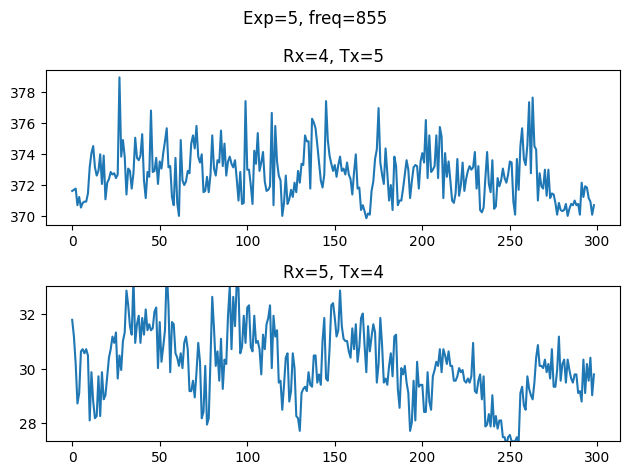

In [17]:
getMPPSignalPlot(5, 4, 5, 855)

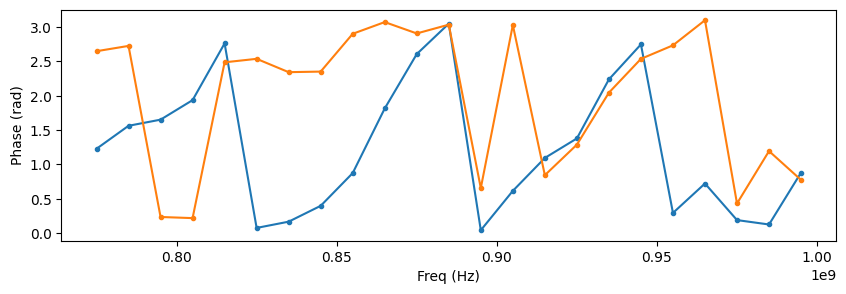

In [18]:
plt.figure(figsize=(10,3))
link1='1-5'
link2='4-5'
l1_ph=[]
l2_ph=[]
for freq in all_freqs.keys():
    exp1=4
    exp2=7
    l1_ph.append(all_freqs[freq][exp1][0][link1])
    l2_ph.append(all_freqs[freq][exp2][0][link2])
    
plt.plot(list(all_freqs.keys()),l1_ph, '.-', label="1-5, exp 0")
plt.plot(list(all_freqs.keys()),l2_ph, '.-', label="4-5, exp 0")
plt.xlabel("Freq (Hz)")
plt.ylabel("Phase (rad)")
plt.show()
# what is the relation between phase change and t2t distance.............
# get distance matrix from slam info
# ability to plot adc voltages for given experiment number and frequency.

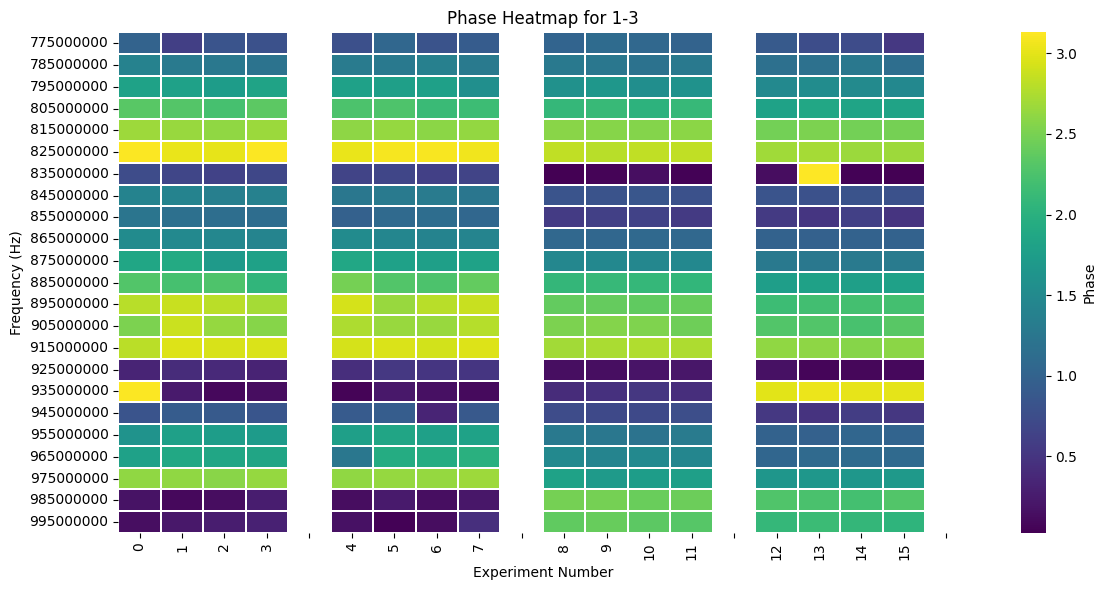

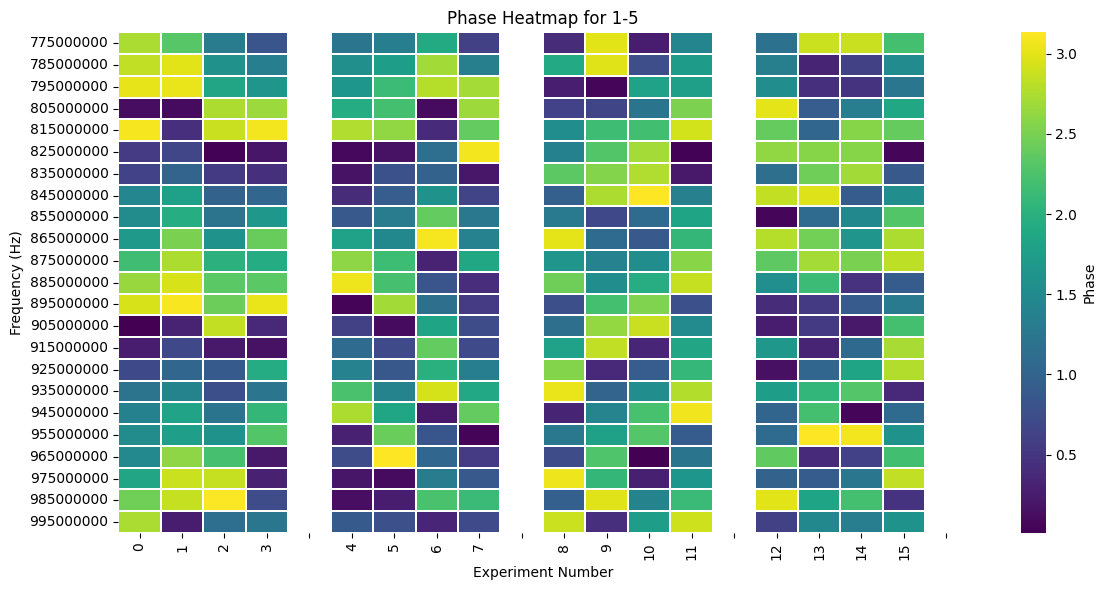

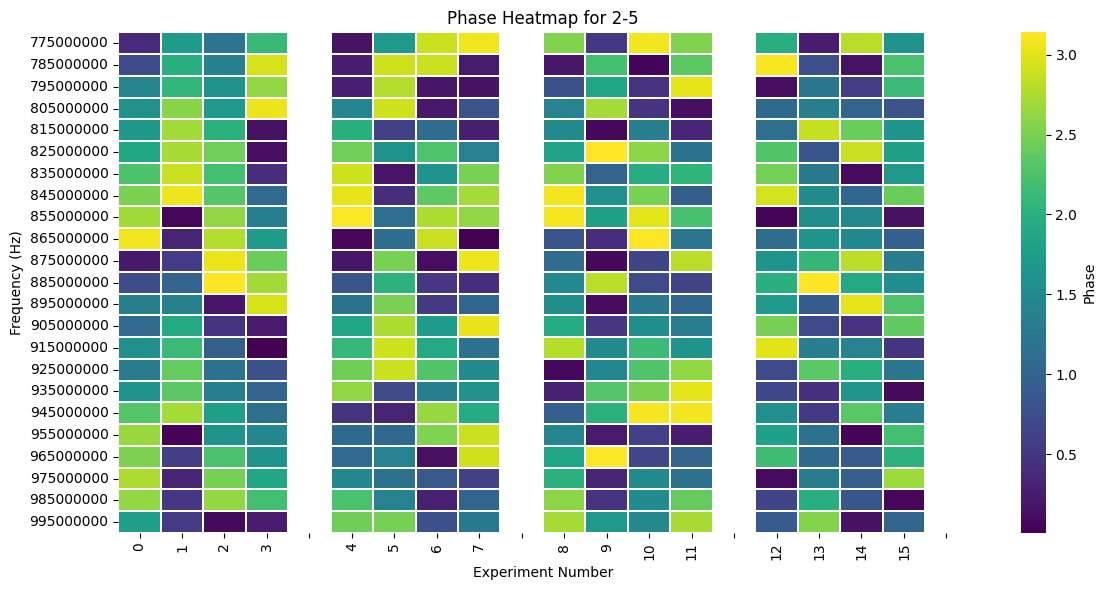

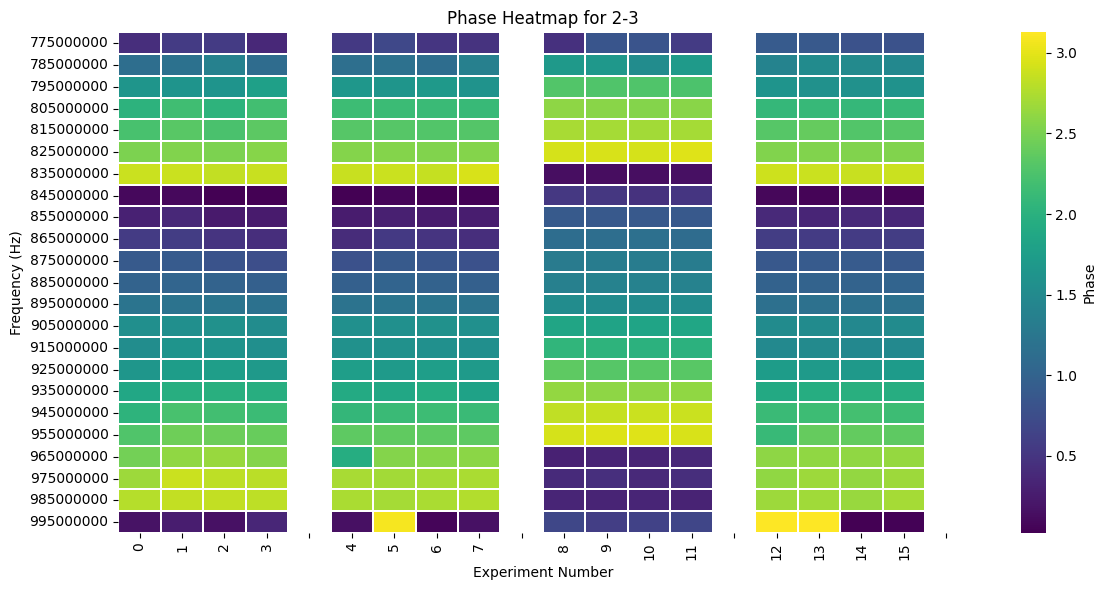

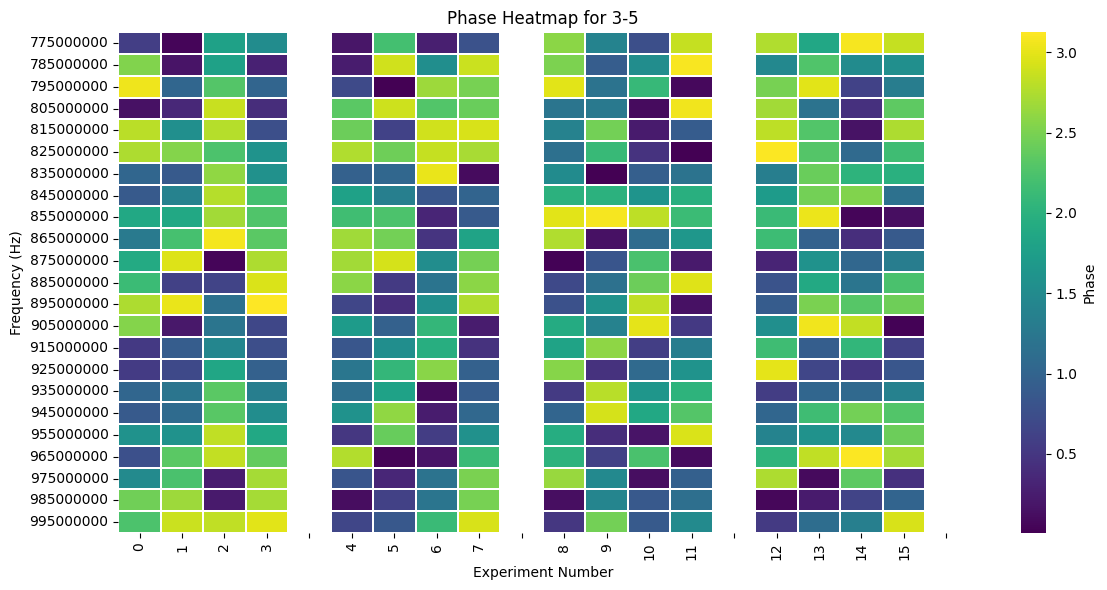

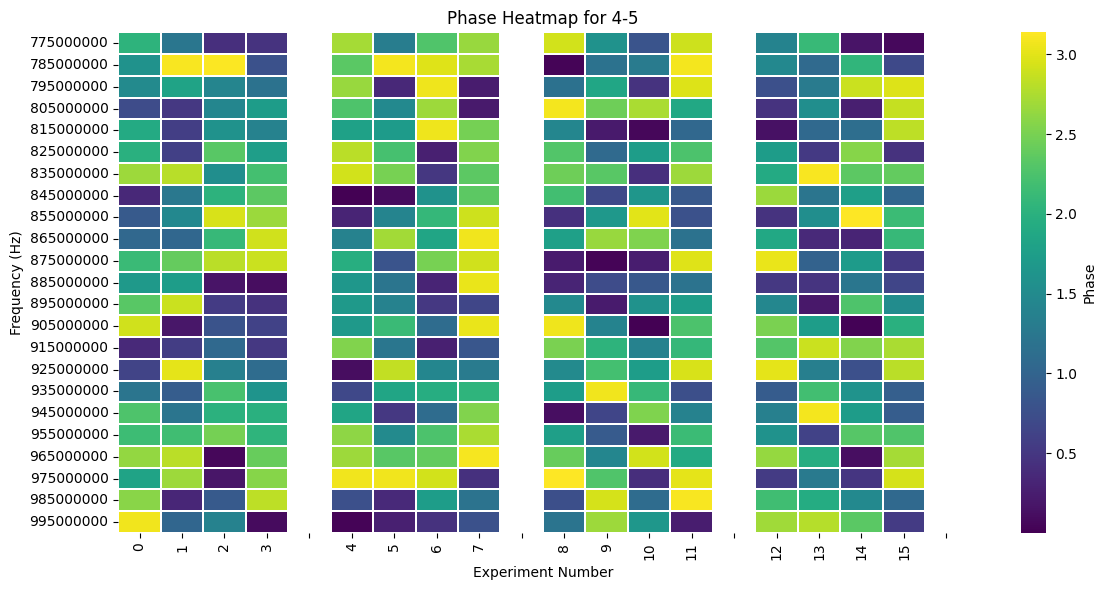

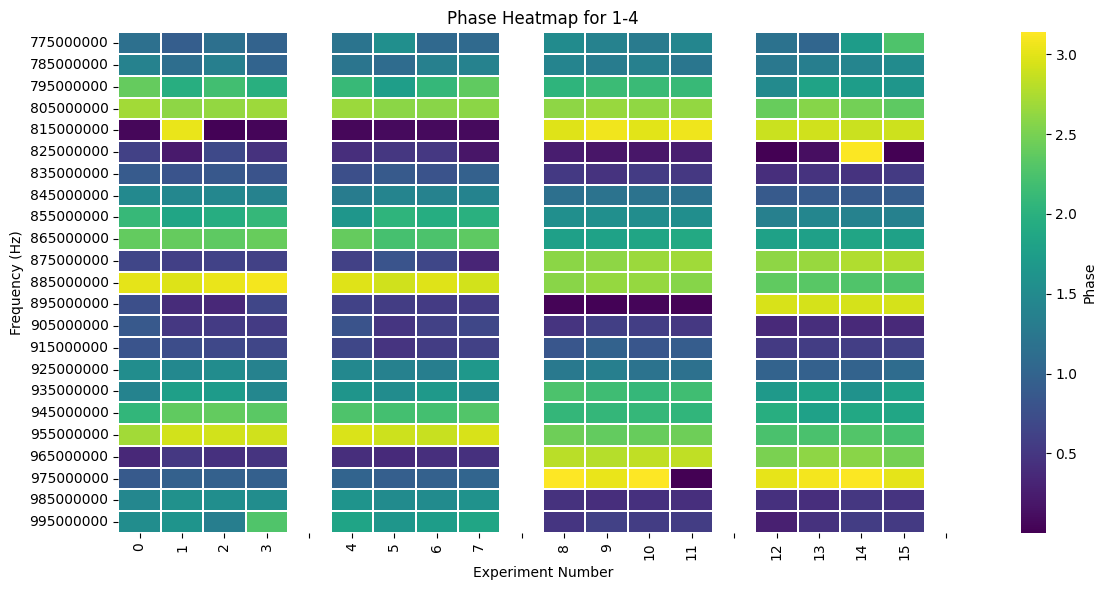

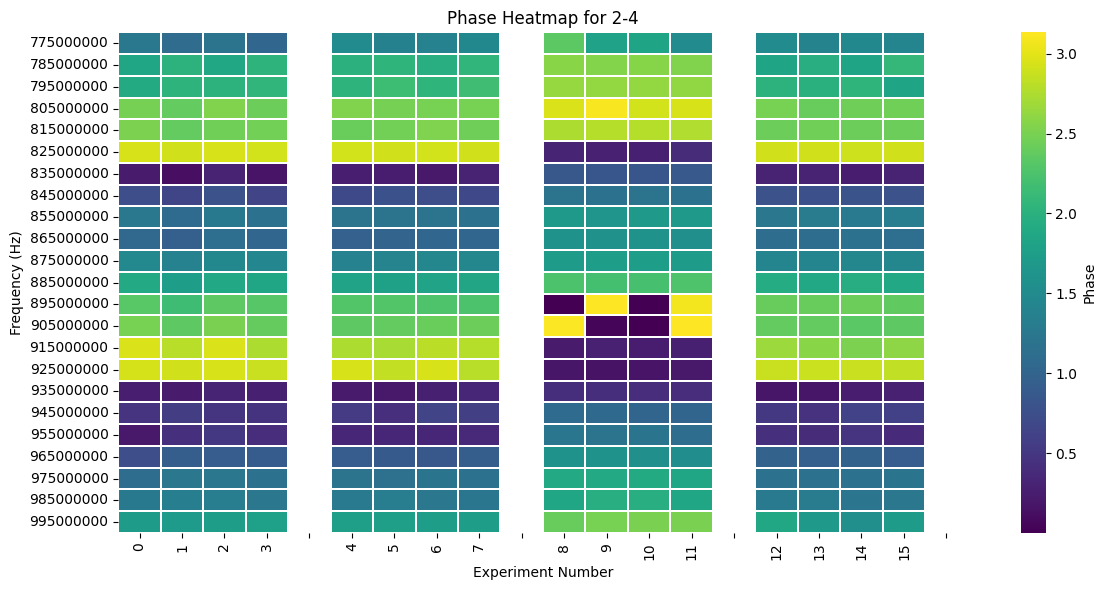

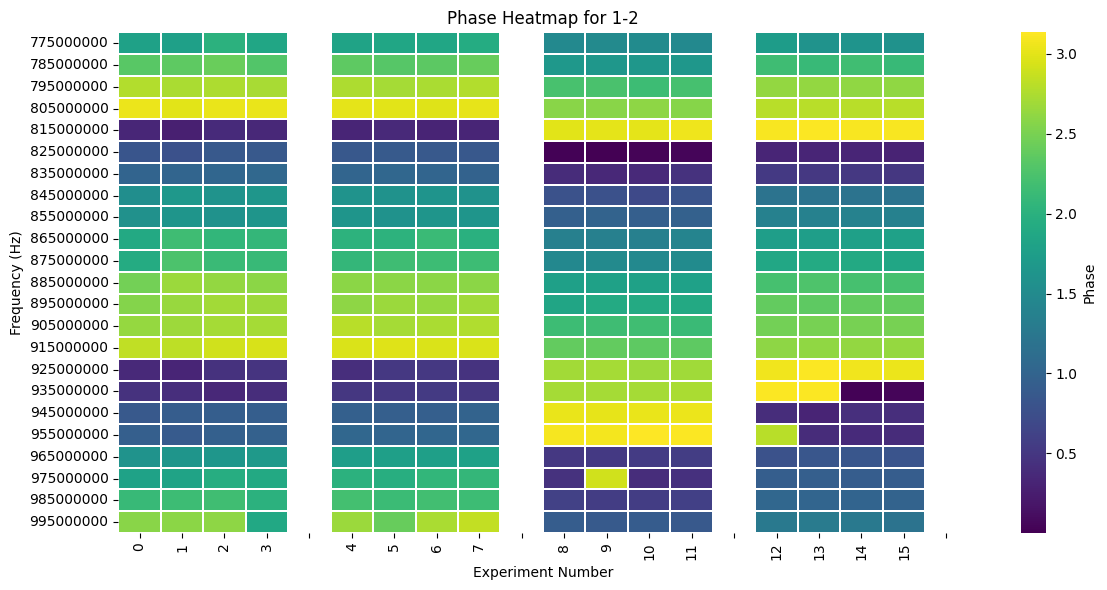

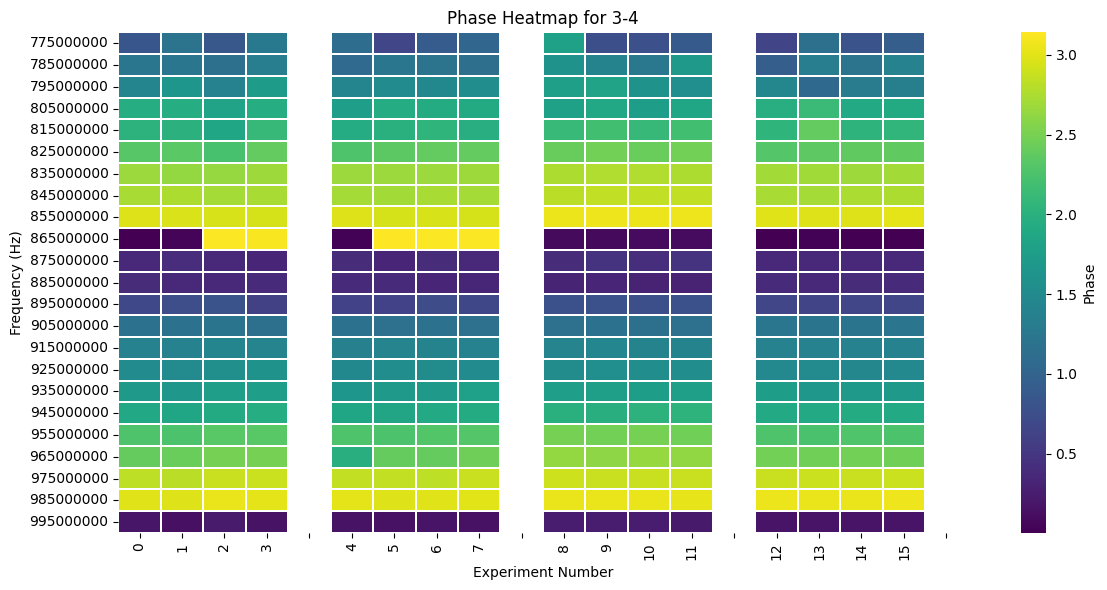

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_phase_heatmaps(data):
    """
    data format:
    {
        freq: {
            exp_num: [ { "tagA-tagB": phase, ... } ]
        }
    }
    """

    # ---- Extract all tag pairs ----
    tag_pairs = set()
    for freq, exp_dict in data.items():
        for exp, tag_list in exp_dict.items():
            tag_pairs.update(tag_list[0].keys())

    frequencies = sorted(data.keys())
    experiment_numbers = sorted({exp for freq in data for exp in data[freq]})

    # ---- Build spacing-aware X-axis ----
    original_exps = experiment_numbers.copy()
    spaced_exps = []
    insert_positions = set()

    for i, exp in enumerate(experiment_numbers):
        spaced_exps.append(exp)
        if (i + 1) % 4 == 0:      # after every 4th experiment
            spaced_exps.append("")   # spacer label
            insert_positions.add(len(spaced_exps) - 1)

    # ---- Create heatmap for each tag ----
    for tag in tag_pairs:

        # Initialize heat matrix
        heat = np.full((len(frequencies), len(spaced_exps)), np.nan)

        for i, f in enumerate(frequencies):

            col = 0
            for j, exp in enumerate(original_exps):

                # Fill actual experiment column
                if exp in data[f]:
                    tag_dict = data[f][exp][0]
                    if tag in tag_dict:
                        heat[i, col] = tag_dict[tag]

                col += 1

                # If a spacer should be added here, skip one column
                if (j + 1) % 4 == 0:
                    col += 1

        # ---- Plot heatmap ----
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            heat,
            xticklabels=spaced_exps,
            yticklabels=frequencies,
            cmap="viridis",
            cbar_kws={"label": "Phase"},
            linewidths=0.2,
            linecolor="white"  # makes spacers more visible
        )

        plt.xlabel("Experiment Number")
        plt.ylabel("Frequency (Hz)")
        plt.title(f"Phase Heatmap for {tag}")

        # Rotate labels
        plt.xticks(rotation=90)

        plt.tight_layout()
        plt.show()

plot_phase_heatmaps(all_freqs)